In [4]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.7 MB/s eta 0:00:00


In [5]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,DataCollatorWithPadding,TFAutoModel,DistilBertConfig,TFDistilBertModel, BertConfig, TFBertModel, TFRobertaModel
from datasets import load_dataset
from google.colab import drive
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score


In [7]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import precision_score, recall_score


# Data Exploration

In [8]:
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/coen346/train.csv.zip")
df_test = pd.read_csv("/content/drive/MyDrive/coen346/test.csv.zip", low_memory=False)
df_sub = pd.read_csv("/content/drive/MyDrive/coen346/sample_submission.csv.zip")

Mounted at /content/drive


In [9]:
len(df['id'].unique()), len(df['qid1'].unique()), len(df['qid2'].unique())

(404290, 290654, 299364)

In [10]:
display(df['qid1'].value_counts(ascending=False))
print("\n")
display(df['qid2'].value_counts(ascending=False))

8461      50
14110     48
1749      47
20628     47
25984     47
          ..
223037     1
223039     1
223041     1
223043     1
537932     1
Name: qid1, Length: 290654, dtype: int64

30782     120
2559      115
4044      100
2561       71
17978      66
         ... 
221429      1
221433      1
133300      1
221437      1
537933      1
Name: qid2, Length: 299364, dtype: int64

# Checking Nulls

In [11]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
nan_qid1 = set(df[df['question1'].isnull()]['qid1'])
nan_qid2 = set(df[df['question2'].isnull()]['qid2'])

nan_ids = nan_qid1.union(nan_qid2)
print(f"These 2 IDs {nan_ids} are NULL. Let's drop them!")

These 2 IDs {493340, 174364} are NULL. Let's drop them!


In [13]:
# dropping the nulls
df.dropna(inplace=True)

# Target Distribution

<Axes: >

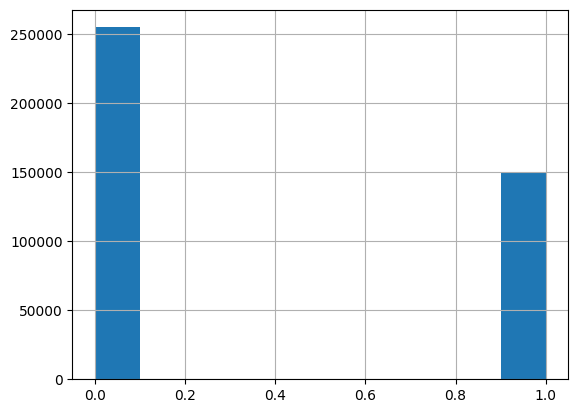

In [14]:
df['is_duplicate'].hist()

# Text Preprocessing

In [47]:
def clean_text(x):

    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = text.lower()

    return text

df['question1_cleaned'] = df['question1'].apply(lambda x : clean_text(x))
df['question2_cleaned'] = df['question2'].apply(lambda x : clean_text(x))

TypeError: ignored

In [16]:
df['question1_length'] = df['question1_cleaned'].apply(lambda x : len(x.split()))
df['question2_length'] = df['question2_cleaned'].apply(lambda x : len(x.split()))

In [17]:
df[['question1_length', 'question2_length']].describe()

,question1_length,question2_length
count,404287.000000,404287.000000
mean,11.127968,11.376792
std,5.571416,6.480827
min,0.000000,0.000000
25%,7.000000,7.000000
50%,10.000000,10.000000
75%,13.000000,13.000000
max,128.000000,248.000000


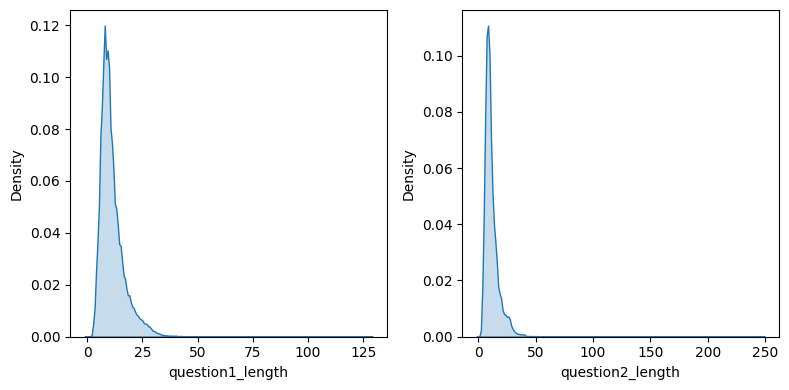

In [18]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(df, x="question1_length", fill=True, ax=axs[0])
sns.kdeplot(df, x="question2_length", fill=True, ax=axs[1])
f.tight_layout()

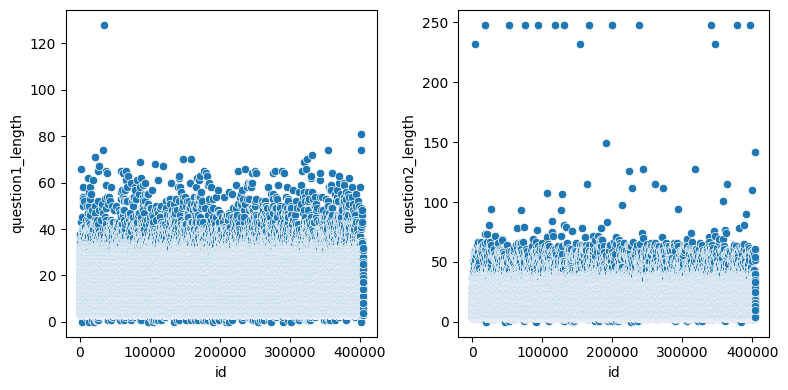

In [19]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data=df, x="id", y="question1_length", ax=axs[0])
sns.scatterplot(data=df, x="id", y="question2_length", ax=axs[1])
f.tight_layout()

In [20]:
# choose ideal token length
Q1 = df['question1_length'].quantile(0.25)
Q3 = df['question1_length'].quantile(0.75)
IQR = Q3-Q1
standard_outlier = Q3 + 1.5*IQR
extreme_outlier = Q3 + 3*IQR

print(f"Lower Q is {Q1} and upper is {Q1}. Hence, IQR is {IQR} \n Standard Out {standard_outlier} \n Extreme Out {extreme_outlier}")

Lower Q is 7.0 and upper is 7.0. Hence, IQR is 6.0 
 Standard Out 22.0 
 Extreme Out 31.0


# Modelling

## Tokenizer

In [21]:
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [22]:
def text_encoding(text):

    encode_out = tokenizer.batch_encode_plus(text,
                                    add_special_tokens=True,
                                    max_length=60,
                                    padding=True,
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors="tf")

    input_ids = np.array(encode_out.get('input_ids'), dtype="int32") # converts list to an array


    return {
         "input_ids": input_ids,
    }

## Splitting the Data

In [23]:
data = df.sample(400000, random_state=42)

N = len(data)
TRAIN_idx = int(np.floor(N*0.8))

train = data.iloc[:TRAIN_idx, :]
val = data.iloc[TRAIN_idx:, :]

train.shape, val.shape

((320000, 10), (80000, 10))

In [24]:
X1_train = text_encoding(train['question1_cleaned'].tolist())
X2_train = text_encoding(train['question2_cleaned'].tolist())

X1_val = text_encoding(val['question1_cleaned'].tolist())

X2_val = text_encoding(val['question2_cleaned'].tolist())

In [25]:
# X
X_train = (np.asarray(X1_train['input_ids']),
           np.asarray(X2_train['input_ids']))

X_val = (np.asarray(X1_val['input_ids']),
           np.asarray(X2_val['input_ids']))

# y
y_train = train['is_duplicate'].values
y_val = val['is_duplicate'].values

## Adding a Distance Layer

In [26]:
class L1Dist(Layer):

    def __init__(self,**kwargs):
        super().__init__()

    def call(self,sequence_avg_output1,sequence_avg_output2):
        return tf.math.abs(sequence_avg_output1 - sequence_avg_output2)

## Build the model

In [27]:


embedding_layer = tf.keras.layers.Embedding(input_dim=30522, output_dim=256)
def build_siamese_model():
  # Input-1
  input_ids1 = Input(shape=(None,), dtype=tf.int32, name="input_ids1")

  # Input-2
  input_ids2 = Input(shape=(None,), dtype=tf.int32, name="input_ids2")

  # Embedding layer
  embedded_seq1 = embedding_layer(input_ids1)
  embedded_seq2 = embedding_layer(input_ids2)

  # LSTM layer
  lstm1 = tf.keras.layers.LSTM(units=64)(embedded_seq1)
  lstm2 = tf.keras.layers.LSTM(units=64)(embedded_seq2)

  # Concatenate LSTM outputs
  concatenated = tf.keras.layers.Concatenate()([lstm1, lstm2])

  # Dropout layer
  dropout = Dropout(0.2)(concatenated)

  # Output layer
  output = Dense(1, activation='sigmoid')(dropout)

  # Build the Siamese model
  model = Model(inputs=[input_ids1, input_ids2], outputs=output)

  return model

# Create an instance of the Siamese model
siamese_model = build_siamese_model()

# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Print the model summary
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids1 (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input_ids2 (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    7813632     ['input_ids1[0][0]',             
                                                                  'input_ids2[0][0]']             
                                                                                                  
 lstm (LSTM)                    (None, 64)           82176       ['embedding[0][0]']          

# Optimize the Model Performance

In [28]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.00000001)

# Train the Model

In [34]:
BATCH_SIZE = 2048
EPOCHS = 20 #5

history = siamese_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping,
               learning_rate_reduction]
)

Epoch 1/20
157/157 [==============================] - 31s 197ms/step - loss: 0.5697 - accuracy: 0.7050 - precision: 0.6352 - recall: 0.4708 - val_loss: 0.5452 - val_accuracy: 0.7258 - val_precision: 0.6485 - val_recall: 0.5669 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - 20s 127ms/step - loss: 0.5064 - accuracy: 0.7524 - precision: 0.7071 - recall: 0.5616 - val_loss: 0.5091 - val_accuracy: 0.7556 - val_precision: 0.7328 - val_recall: 0.5353 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - 21s 135ms/step - loss: 0.4704 - accuracy: 0.7740 - precision: 0.7246 - recall: 0.6251 - val_loss: 0.4998 - val_accuracy: 0.7583 - val_precision: 0.7190 - val_recall: 0.5703 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - 17s 109ms/step - loss: 0.4475 - accuracy: 0.7852 - precision: 0.7351 - recall: 0.6532 - val_loss: 0.5145 - val_accuracy: 0.7577 - val_precision: 0.6846 - val_recall: 0.6407 - lr: 0.0010
Epoch 5/20
157/157 [====================

# Fine-tuning

In [ ]:
# Unfreeze the bert_model.

# bert_model.trainable = True
# # Recompile the model to make the change effective.
# model.compile(
#     optimizer=Adam(1e-5),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )

# model.summary()

In [ ]:
# history = model.fit(
#     train_data,
#     validation_data=valid_data,
#     epochs=epochs,
#     use_multiprocessing=True,
#     workers=-1,
# )

# Model Prediction & Evaluation

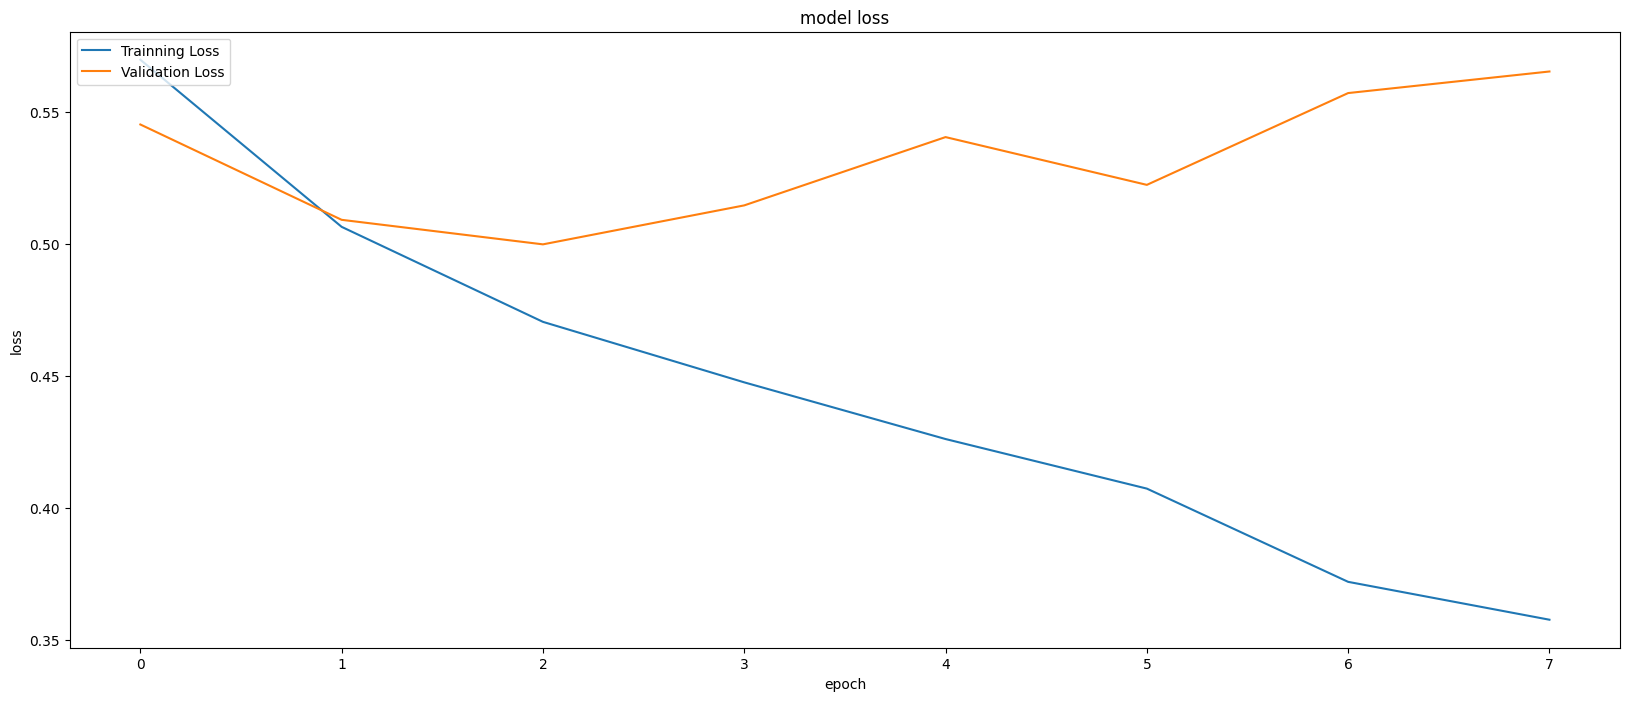

In [40]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Trainning Loss', 'Validation Loss'], loc='upper left')
plt.show()

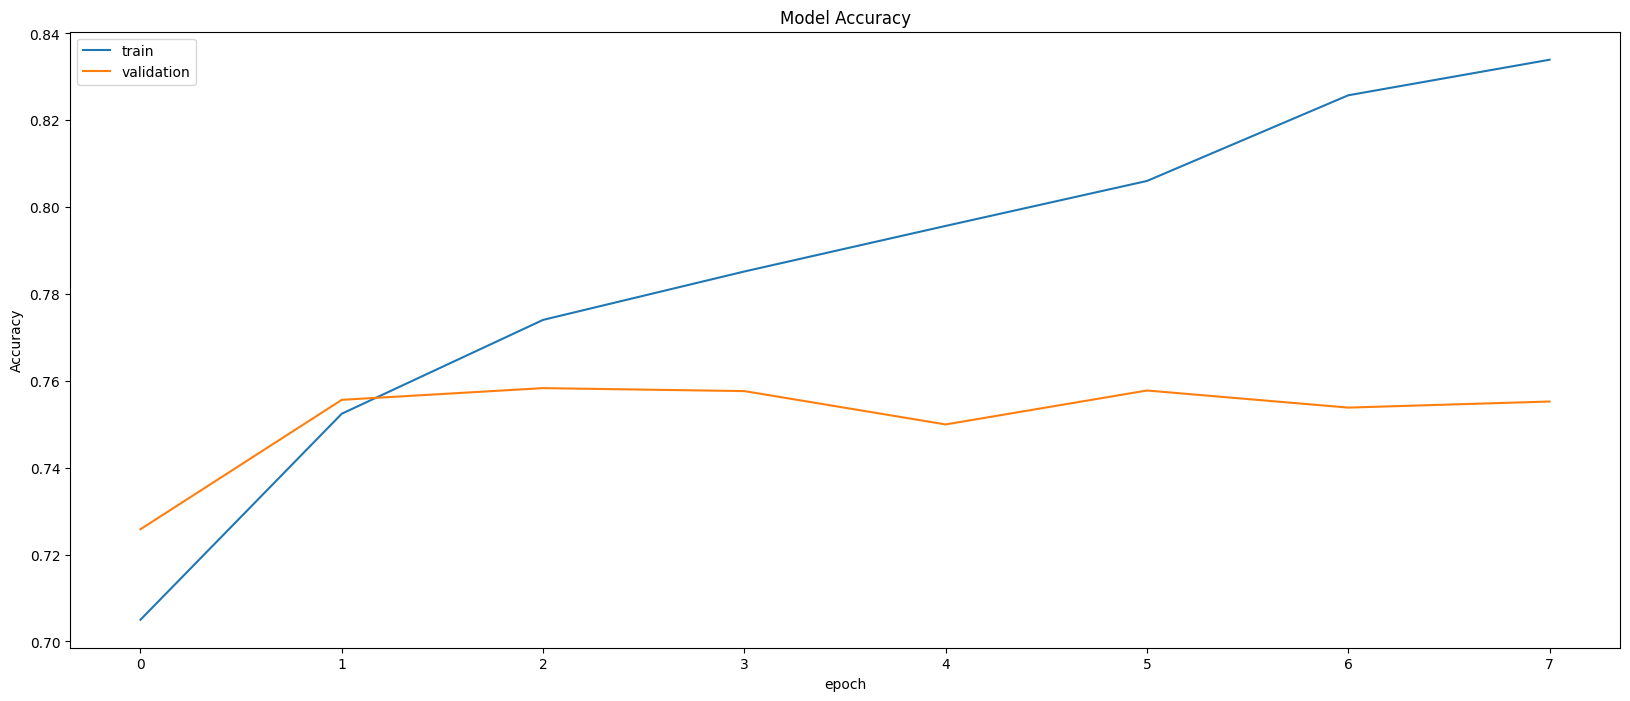

In [36]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Trainning Accuarcy', 'Validation Accuarcy'], loc='upper left')
plt.show()

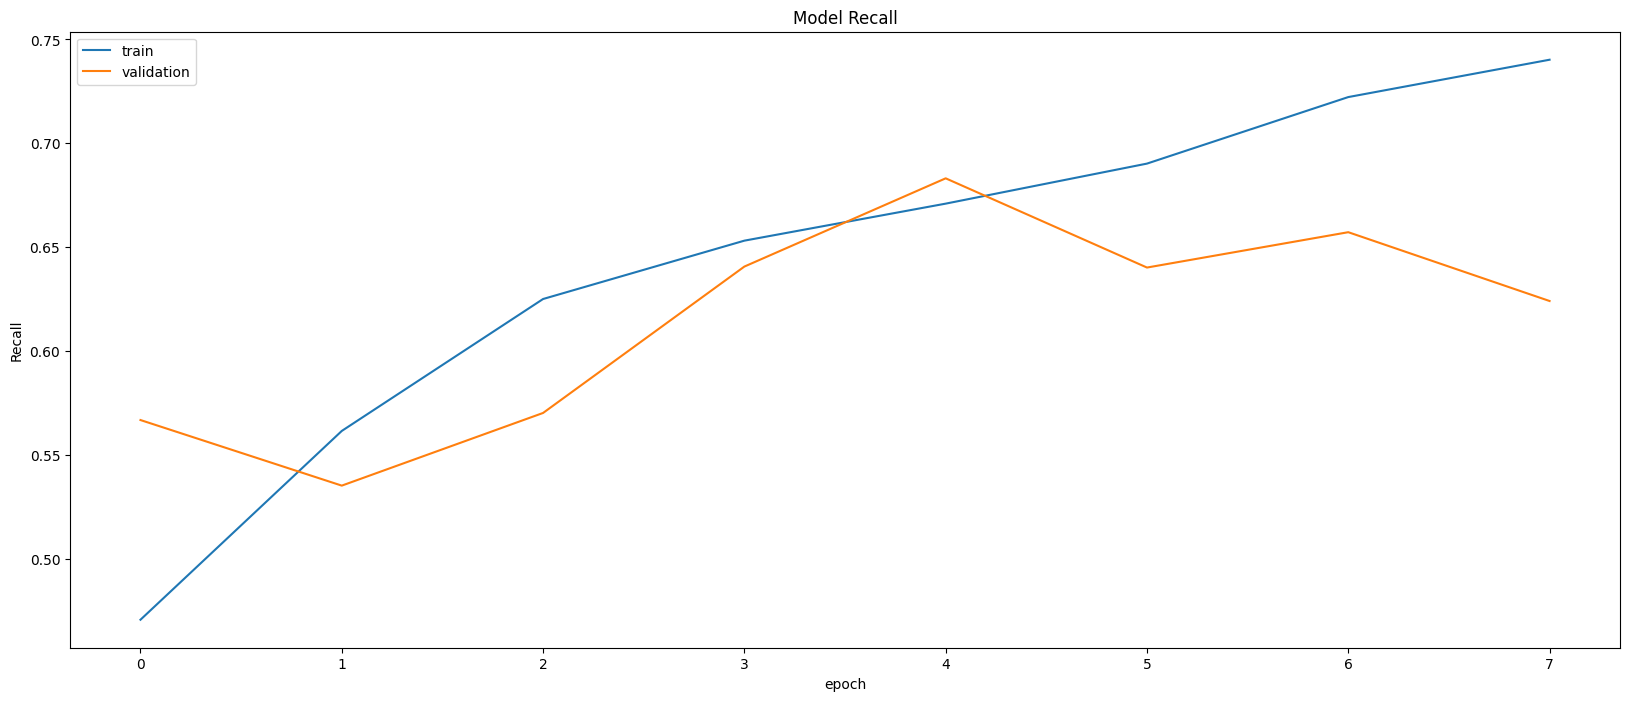

In [37]:
plt.figure(figsize=(20,8))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['Trainning Recall', 'Validation Recall'], loc='upper left')
plt.show()

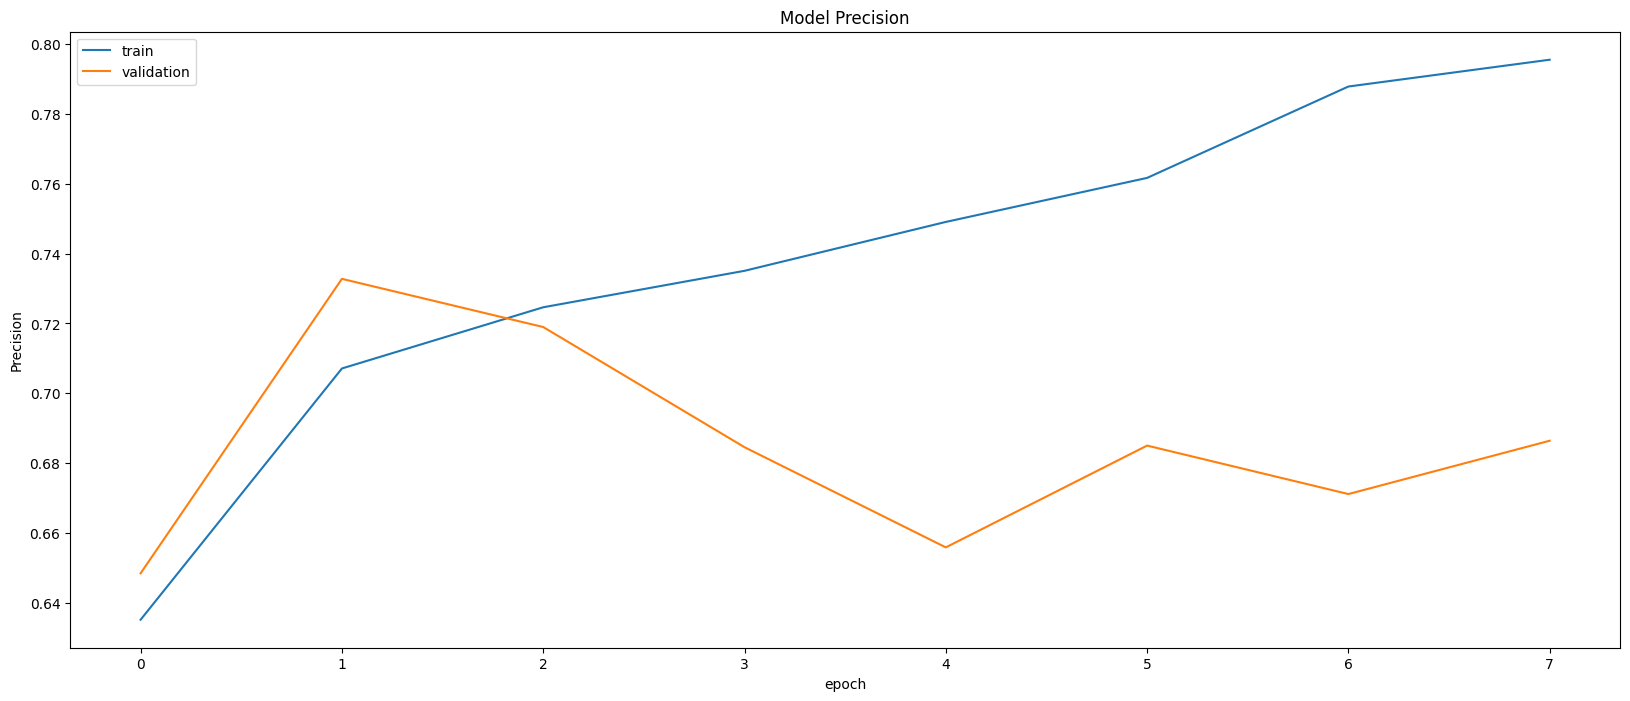

In [39]:
plt.figure(figsize=(20,8))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['Trainning Precision', 'Validation Precisio'], loc='upper left')
plt.show()

In [46]:
X1_test = text_encoding(df_test['question1'].tolist())
X2_test = text_encoding(df_test['question2'].tolist())

X_test = (np.asarray(X1_test['input_ids']),
          np.asarray(X2_test['input_ids']))


TypeError: ignored

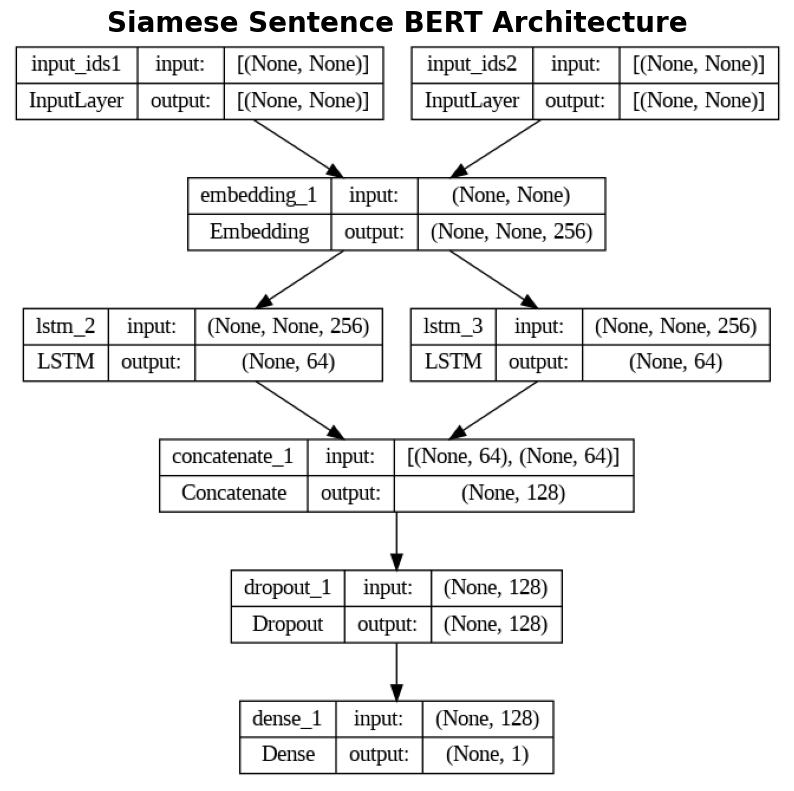

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Generate the model architecture plot
plot_model(siamese_model, to_file='siamese_sentence_BERT_architecture.png', show_shapes=True)

# Load the image and add formatting
image = plt.imread('siamese_sentence_BERT_architecture.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# Add title and remove axes
ax.set_title('Siamese Sentence BERT Architecture', fontsize=20, fontweight='bold')
ax.axis('off')

# Add a border around the plot
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)

# Add a background color to the plot
ax.patch.set_facecolor('#f9f9f9')
ax.patch.set_alpha(0.9)

# Save and display the plot
plt.savefig('formatted_logistic_regression_model_architecture.png', bbox_inches='tight', pad_inches=0);